### Check GPUs

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
#!pip install visualkeras

### Import Libraries

In [6]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from sklearn.metrics import confusion_matrix , classification_report
#import visualkeras
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data

In [8]:
data = pd.read_csv('/content/drive/MyDrive/skincancer_mnist_ham/hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel2313,pixel2314,pixel2315,pixel2316,pixel2317,pixel2318,pixel2319,pixel2320,pixel2321,pixel2322,pixel2323,pixel2324,pixel2325,pixel2326,pixel2327,pixel2328,pixel2329,pixel2330,pixel2331,pixel2332,pixel2333,pixel2334,pixel2335,pixel2336,pixel2337,pixel2338,pixel2339,pixel2340,pixel2341,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,162,192,208,165,201,209,165,205,208,165,194,212,169,198,216,181,204,216,178,204,215,172,205,217,173,209,217,166,202,214,...,216,181,212,215,176,208,213,168,191,209,159,184,212,168,194,212,172,198,208,173,193,203,168,183,190,142,152,177,123,134,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,128,158,172,136,162,175,134,157,177,126,158,186,138,163,197,153,187,198,153,186,203,168,206,205,169,204,207,164,199,205,...,209,176,203,207,171,191,208,172,197,205,169,188,198,159,172,200,159,192,191,140,182,177,128,141,147,101,97,113,79,82,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,149,165,207,149,159,209,156,164,202,136,130,200,133,129,208,146,157,212,159,167,214,157,168,211,143,150,215,148,169,213,...,221,168,175,222,170,188,221,167,184,203,144,155,201,146,155,210,163,177,190,142,152,192,152,172,194,153,176,178,134,149,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,125,134,177,118,123,190,137,146,192,127,143,200,141,162,207,156,170,202,144,151,202,138,155,212,159,177,211,155,172,211,...,181,137,145,189,147,166,192,157,185,169,129,144,148,114,122,157,125,137,157,127,147,154,128,147,130,102,114,87,63,73,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,179,214,232,189,222,235,193,219,234,191,206,238,200,219,244,213,240,243,213,239,242,210,238,244,216,241,247,224,244,246,...,238,195,209,237,191,200,238,194,201,239,197,216,238,195,219,232,179,201,217,150,173,224,171,207,227,177,206,222,178,201,209,166,185,172,135,149,109,78,92,2


In [9]:
meta = pd.read_csv('/content/drive/MyDrive/skincancer_mnist_ham/HAM10000_metadata.csv')
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Data Cleaning

Drop the 'label' column is taken as the target label and the remaining columns are taken as the features.

In [10]:
y = data['label']
x = data.drop(columns = ['label'])
x.shape

(10015, 2352)

The 'dx' column in the 'meta' dataframe contains the exact names of each type of skin cancer. We'll create a dictionary to generate easy to understand labels.

In [11]:
classes = {0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           1:('bcc' , ' basal cell carcinoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           3: ('df', 'dermatofibroma'),
           4: ('nv', ' melanocytic nevi'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           6: ('mel', 'melanoma') 
           }

### Random Oversampling to Balance Data

In [12]:
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)
x = np.array(x).reshape(-1,28,28,3)
print('Shape of Data :',x.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of Data : (46935, 28, 28, 3)


Visualize newly balanced data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


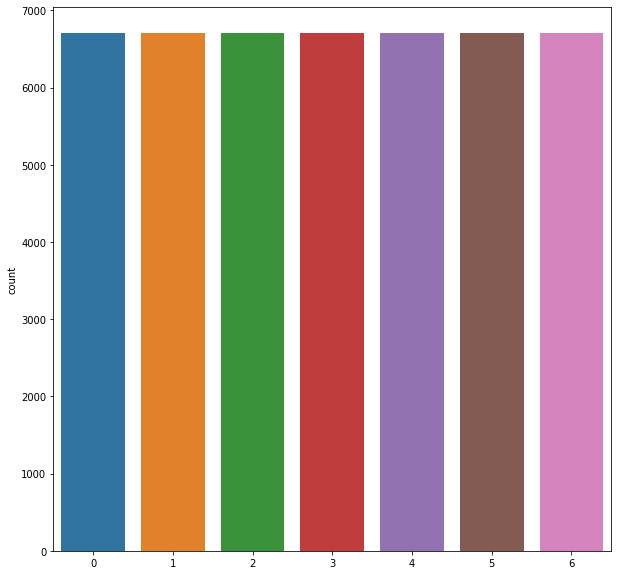

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.countplot(y)

Standardize Data

In [13]:
x = (x-np.mean(x))/np.std(x)

### Split Data

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=42)

### Build Model

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0

View Model Architecture

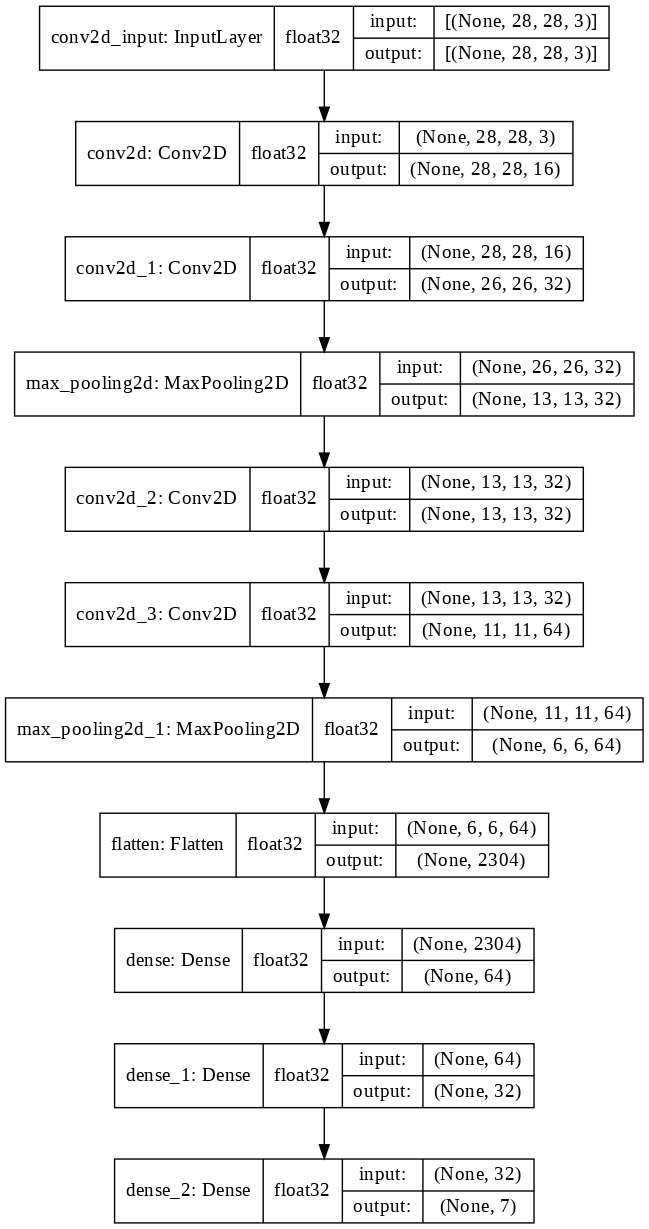

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True, show_dtype = True, show_layer_names = True, rankdir="TB", expand_nested = True, dpi = 100)

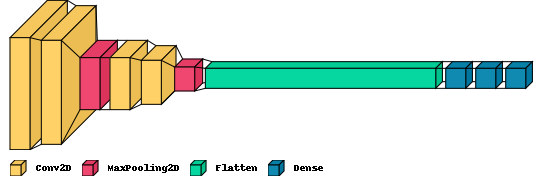

In [ ]:
visualkeras.layered_view(model, legend=True,to_file='skin_cancer_architecture.png') 

Set Checkpoints to stop model early and prevent overfitting.

In [ ]:
Checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_skincancer_model.h5',
                                                  monitor='val_loss', mode='max',
                                                 verbose=0)
File = 'SkinDiseases'
callback = [Checkpoint, 
             tf.keras.callbacks.EarlyStopping(patience = 5, monitor= "val_acc",verbose=1),
             tf.keras.callbacks.TensorBoard(log_dir = "logs/{}".format(File))]

Compile Model

In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])

### Train Model

In [ ]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 60,
                    callbacks=[callback])

Epoch 1/60
235/235 [==============================] - 34s 13ms/step - loss: 1.1846 - accuracy: 0.5376 - val_loss: 0.8923 - val_accuracy: 0.6748
Epoch 2/60
235/235 [==============================] - 2s 7ms/step - loss: 0.6966 - accuracy: 0.7402 - val_loss: 0.6133 - val_accuracy: 0.7659
Epoch 3/60
235/235 [==============================] - 2s 8ms/step - loss: 0.4516 - accuracy: 0.8335 - val_loss: 0.4266 - val_accuracy: 0.8490
Epoch 4/60
235/235 [==============================] - 2s 7ms/step - loss: 0.3250 - accuracy: 0.8836 - val_loss: 0.3122 - val_accuracy: 0.8866
Epoch 5/60
235/235 [==============================] - 2s 8ms/step - loss: 0.2323 - accuracy: 0.9175 - val_loss: 0.2478 - val_accuracy: 0.9112
Epoch 6/60
235/235 [==============================] - 2s 7ms/step - loss: 0.1792 - accuracy: 0.9378 - val_loss: 0.2441 - val_accuracy: 0.9168
Epoch 7/60
235/235 [==============================] - 2s 7ms/step - loss: 0.1576 - accuracy: 0.9435 - val_loss: 0.1920 - val_accuracy: 0.9349
Epoc

### Plot Accuracy

Plot accuracy for train vs test

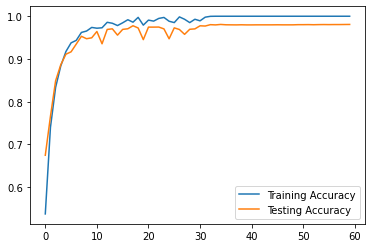

In [ ]:
plt.plot(history.history["accuracy"] , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , label = "Testing Accuracy")
plt.legend()
plt.show()

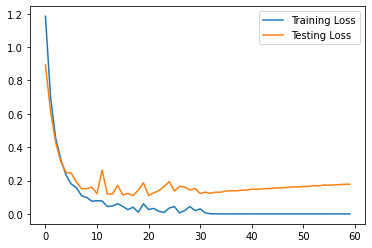

In [ ]:
plt.plot(history.history["loss"] , label = "Training Loss")
plt.plot(history.history["val_loss"] , label = "Testing Loss")
plt.legend()
plt.show()

### Obtain Predictions

In [15]:
Y_train_1hot = to_categorical(Y_train)
Y_test_1hot = to_categorical(Y_test)

In [16]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/fitz_model_weights/skincancer_98.h5')

In [17]:
Y_pred  = model.predict(X_test).round()

###Sensitivity Score

In [18]:
Y_test_new = Y_test_1hot.argmax(axis = 1)

In [19]:
Y_pred_new = Y_pred.argmax(axis = 1)

In [ ]:
from imblearn.metrics import sensitivity_score
sensitivity_score(Y_test_new, Y_pred_new, average=None).round()

array([1., 1., 1., 1., 1., 1., 1.])

### Specificity Score

In [20]:
Y_test_new = Y_test_1hot.argmax(axis = 1)

In [21]:
Y_pred_new = Y_pred.argmax(axis = 1)

In [ ]:
from imblearn.metrics import specificity_score
specificity_score(Y_test_new, Y_pred_new, average=None).round()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


array([1., 1., 1., 1., 1., 1., 1.])

### Generate Report

In [ ]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(Y_test_1hot , Y_pred , target_names =target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       0.99      1.00      1.00      1295
                             ('bcc', ' basal cell carcinoma')       0.99      1.00      0.99      1323
                     ('bkl', 'benign keratosis-like lesions')       0.96      0.99      0.97      1351
                                     ('df', 'dermatofibroma')       1.00      1.00      1.00      1392
                                  ('nv', ' melanocytic nevi')       0.99      0.89      0.93      1346
              ('vasc', ' pyogenic granulomas and hemorrhage')       1.00      1.00      1.00      1292
                                          ('mel', 'melanoma')       0.95      0.99      0.97      1388

                                                    micro avg       0.98      0.98      0.98      9387
                                                    macro avg       0.9

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

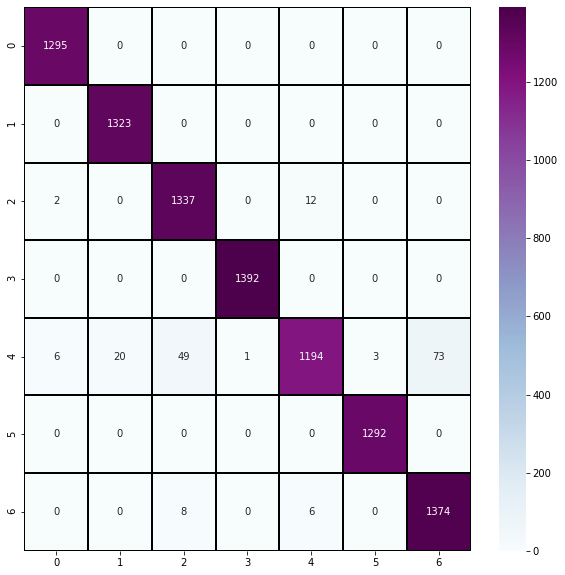

In [ ]:
cm = confusion_matrix(Y_test_1hot.argmax(axis = 1) , Y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "BuPu", linecolor = 'black' , linewidth = 1 , annot = True, fmt='');

### Test Model

In [ ]:
loss, acc = model.evaluate(X_test, Y_test, verbose=2)

294/294 - 1s - loss: 0.1847 - accuracy: 0.9808


ROC

In [1]:
fpr = dict()
tpr = dict()
roc_auc = dict()
from sklearn.metrics import roc_curve, auc

In [22]:
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(Y_test_1hot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [23]:
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_1hot.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

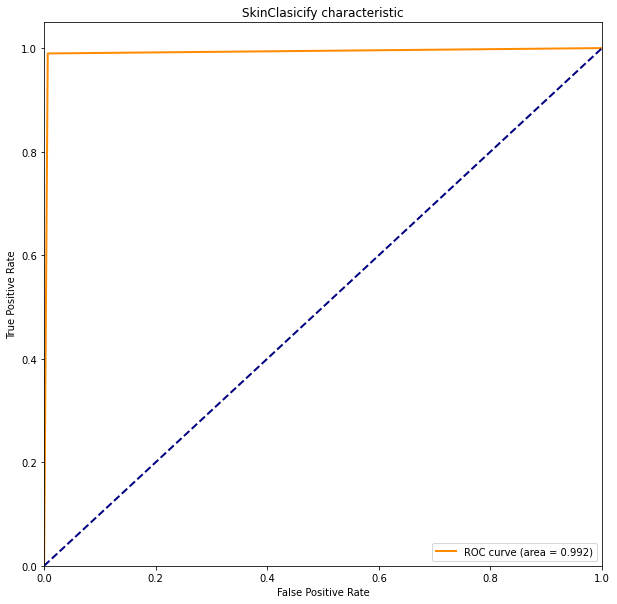

In [25]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SkinClasicify characteristic')
plt.legend(loc="lower right")
plt.show()

### Inference

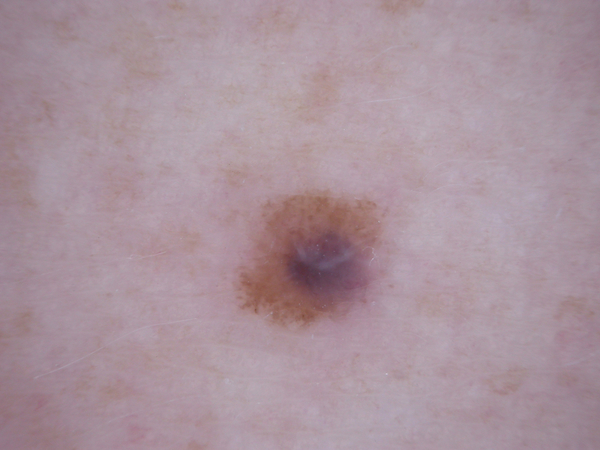

('nv', ' melanocytic nevi')


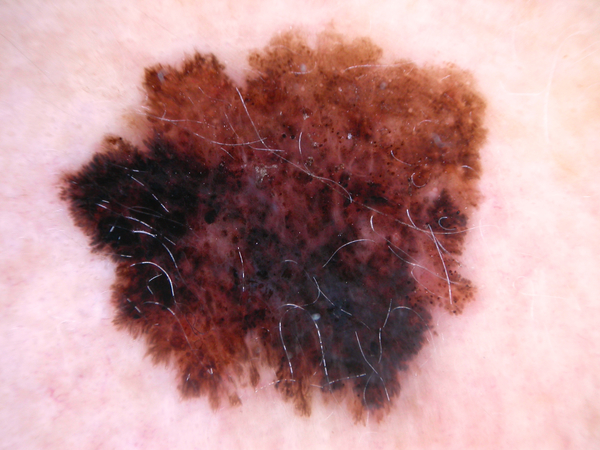

('nv', ' melanocytic nevi')


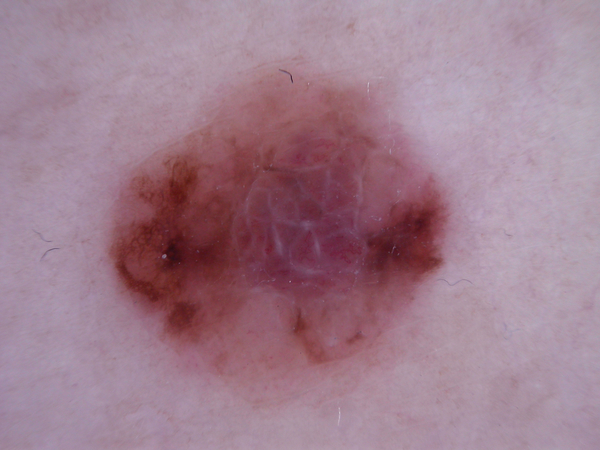

('nv', ' melanocytic nevi')


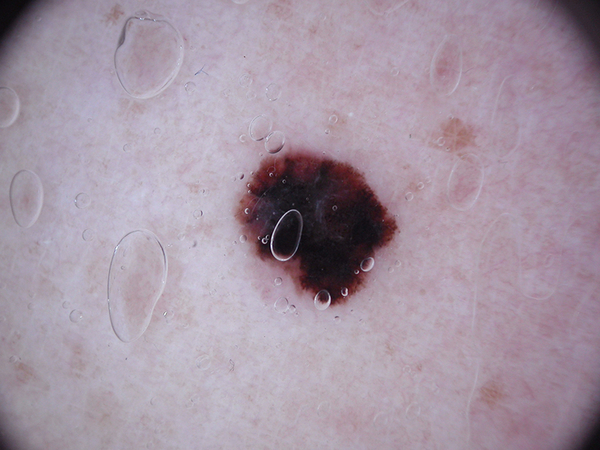

('nv', ' melanocytic nevi')


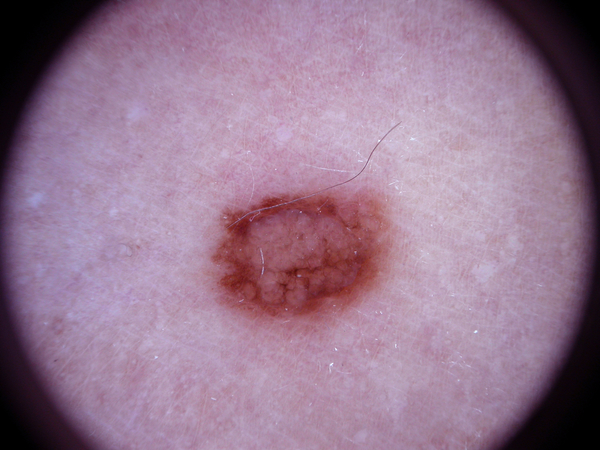

('nv', ' melanocytic nevi')


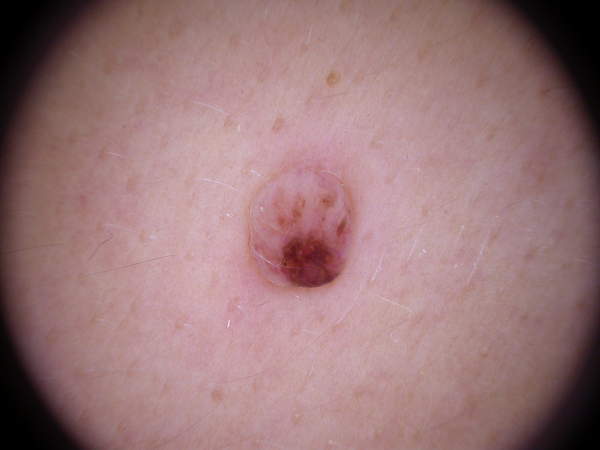

('nv', ' melanocytic nevi')


In [ ]:
srcdir = '/content/drive/MyDrive/skincancer_mnist_ham/HAM10000_images_part_2'
count=0
for temp in os.listdir(srcdir):
    img = cv2.imread(os.path.join(srcdir, temp))
    cv2.imwrite(temp, img)
    cv2_imshow(img)
    img = cv2.resize(img, (28, 28))
    result = model.predict(img.reshape(1, 28, 28, 3))
    max_prob = max(result[0])
    class_ind = list(result[0]).index(max_prob)
    class_name = classes[class_ind]
    print(class_name)
    count+=1
    if count>5:
        break

In [ ]:
#model.save("/content/drive/MyDrive/fitz_model_weights/skincancer_98.h5")